# Feedforward NN

In [1]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvalsh 

In [2]:
%matplotlib inline

### Data generation

In [3]:
# Physical data
l = 200
tau = 100
dep = 2
# Numerical data
nx = 200
dx = l/(nx+1)
nt = 200
dt = tau/nt
T_operator = 1/100*dx*np.tri(nt, nx, 0, dtype=int)

In [87]:
# training data
ntrain = 1
x_dagger = np.zeros((ntrain,1,nx))
x_init = np.zeros((ntrain,1,nx))
y = np.zeros((ntrain,1,nt))
x_grid = np.linspace(0,l,nx)
for i in range(0,ntrain):
    # value for x
    mu = l/2
    sigma = 0.1
    x_dagger[i,0,:] = (sigma*np.sqrt(2*np.pi))**-1*np.exp(-(x_grid-mu)**2/2*sigma**2)
    y[i,0,:] = T_operator.dot(x_dagger[i,0,:]) 
    xi = np.random.uniform(-0.05,0.05,nt)
    y[i,0,:] += 0.05*xi*np.linalg.norm(y[i,0,:])/np.linalg.norm(xi)


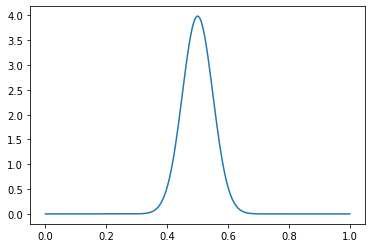

In [88]:
plt.plot(np.linspace(0,1,nx),x_dagger[0,0,:])

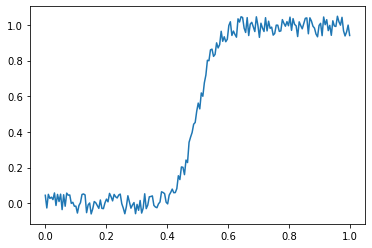

In [122]:
plt.plot(np.linspace(0,1,nt),y[0,0,:])

### Neural Network

In [123]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss

    # predict output for given input
    def predict(self, input_data,y):
        # sample dimension first
        samples = len(input_data)
        result = []
        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output,obs=y[i])
            result.append(output)
        plt.show()
        return result


In [124]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input, obs):
        raise NotImplementedError


In [125]:
# inherit from base class Layer
class WeightLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, T, coeff=0.02):
        self.weights = coeff*np.transpose(T).dot(T)
        self.bias = coeff*np.transpose(T)

    # returns output for a given input
    def forward_propagation(self, input_data,obs):
        self.input = input_data
        self.output = input_data - (np.dot(self.weights,self.input[0,:])\
         - np.dot(self.bias,obs[0,:]))
        return self.output


In [126]:
# Activations functions
def tanh(x,alpha=0.02):
    xp = x.copy()
    xp [x<0] = 0
    return alpha*np.tanh(x/alpha)

def relu(x,alpha=0.02):
    xp = x.copy()
    xp [x<0] = 0
    return xp/(alpha+1)

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation,alpha): # activation_prime pour backpropagation
        self.activation = lambda x : activation(x,alpha)

    # returns the activated input
    def forward_propagation(self, input_data, obs):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output


In [150]:
# network
net = Network()
# number of layers
nlayers = 40

coeff = 2/eigvalsh(np.transpose(T_operator).dot(T_operator)).max()
print(coeff)

1.2398550006605176


In [159]:
i=0
while i < nlayers:
    net.add(WeightLayer(T_operator,coeff))
    net.add(ActivationLayer(relu,alpha=coeff*0.0))
    i+=1

In [160]:
x_t = net.predict(np.transpose(T_operator).dot(y[0,0,:]).reshape(1,1,-1),y)

In [161]:
np.shape(x_t)

(1, 1, 200)

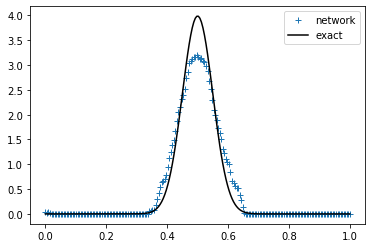

In [163]:
plt.plot(np.linspace(0,1,nx),x_t[0][0,:],'+', label = "network")
plt.plot(np.linspace(0,1,nx),x_dagger[0,0,:],'k-',label ="exact")
plt.legend()